## Simple EDA to understand the dataset
- whats in our dataset
- what do they look like

In [106]:
import pandas as pd
import numpy as np

In [107]:
%%time
train = pd.read_csv('./data/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
# note: this process took 2min 10scs on my computer

CPU times: user 1min 57s, sys: 19.3 s, total: 2min 17s
Wall time: 2min 16s


In [108]:
train_df = train

In [109]:
train_df.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [110]:
train_df.shape

(629145480, 2)

In [8]:
%%time
sample_sub = pd.read_csv('./data/sample_submission.csv')

FileNotFoundError: [Errno 2] File b'./data/sample_submission.csv' does not exist: b'./data/sample_submission.csv'

In [6]:
sample_sub.head()

,seg_id,time_to_failure
0,seg_00030f,0
1,seg_0012b5,0
2,seg_00184e,0
3,seg_003339,0
4,seg_0042cc,0


In [7]:
sample_test = pd.read_csv('./data/test/seg_0a0fbb.csv')

In [8]:
sample_test.head()

,acoustic_data
0,3
1,-3
2,-1
3,6
4,8


In [9]:
sample_test.shape

(150000, 1)

## Calculate aggregated features

## LSTM Using Keras

In [113]:
chunk_size = 150000

chunks = int(np.floor(train_df.shape[0]/chunk_size))

X_data = pd.DataFrame(index=range(chunks), dtype=np.float32, columns=['min','max','std', 'avg', 'sum', 'median', 'mean_diff', 
                                                                       'q05', 'q25', 'q75', 'q95'])
y_data = pd.DataFrame(index=range(chunks), dtype=np.float32, columns=['ttf'])

def create_features(data_chunk, X_df, chunk_no, col_name='acoustic_data'):
    x = data_chunk[col_name]
    X_df.loc[chunk_no, 'min'] = x.min()
    X_df.loc[chunk_no, 'max'] = x.max()
    X_df.loc[chunk_no, 'std'] = x.std()
    X_df.loc[chunk_no, 'avg'] = x.mean()
    X_df.loc[chunk_no, 'sum'] = x.sum()
    X_df.loc[chunk_no, 'median'] = x.median()
    X_df.loc[chunk_no, 'mean_diff'] = np.mean(np.diff(x))
    X_df.loc[chunk_no, 'q05'] = np.quantile(x, 0.05)
    X_df.loc[chunk_no, 'q25'] = np.quantile(x, 0.25)
    X_df.loc[chunk_no, 'q75'] = np.quantile(x, 0.75)
    X_df.loc[chunk_no, 'q95'] = np.quantile(x, 0.95)
    return X_df

In [114]:
from tqdm import tqdm
for chunk_no in tqdm(range(chunks)):
    data_chunk = train_df.iloc[chunk_no*chunk_size:chunk_no*chunk_size+chunk_size]
    X_data = create_features(data_chunk, X_data, chunk_no)
    y = data_chunk['time_to_failure'].values[-1]
    y_data.loc[chunk_no, 'ttf'] = y

100%|██████████| 4194/4194 [01:17<00:00, 53.95it/s]


In [115]:
print(X_data.shape)
print(y_data.shape)
print(X_data.shape[1])
X_data.head()

(4194, 11)
(4194, 1)
11


,min,max,std,avg,sum,median,mean_diff,q05,q25,q75,q95
0,-98.0,104.0,5.101106,4.884113,732617.0,5.0,-0.000080,-2.0,3.0,7.0,11.0
1,-154.0,181.0,6.588824,4.725767,708865.0,5.0,0.000000,-2.0,2.0,7.0,12.0
2,-106.0,140.0,6.967397,4.906394,735959.0,5.0,-0.000013,-3.0,2.0,7.0,13.0
3,-199.0,197.0,6.922305,4.902240,735336.0,5.0,0.000000,-2.0,2.0,7.0,12.0
4,-126.0,145.0,7.301110,4.908720,736308.0,5.0,-0.000007,-2.0,2.0,7.0,12.0


In [116]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data.values, y_data.values, test_size=0.2)
# X_test
# X_data.values
X_train.shape

(3355, 11)

In [121]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, Bidirectional
from keras.optimizers import adam
from keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(Bidirectional(LSTM(512, kernel_initializer="RandomUniform", input_shape= (X_train.shape[1], 1), return_sequences = True)))
#model.add(CuDNNGRU(64, kernel_initializer="RandomUniform", input_shape= (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(256, dropout = 0.3, recurrent_dropout = 0.3))
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
# model.add(Flatten())
model.add(Dense(1))


In [122]:


# Reshaping for fit
# X_train_array = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_train_array = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train_array = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))

# model.compile(loss="mean_squared_error", optimizer="rmsprop", metrics=["mse"])
opt = keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss="mean_absolute_error", optimizer=opt, metrics=["mae", "mse"])
#model.summary()

build = model.fit(X_train_array, y_train, epochs=150, batch_size=30, validation_split = 0.20, verbose=1, shuffle = True)

Train on 2684 samples, validate on 671 samples
Epoch 1/150
2684/2684 [==============================] - 24s 9ms/step - loss: 5.2773 - mae: 5.2773 - mse: 40.8270 - val_loss: 4.5982 - val_mae: 4.5982 - val_mse: 32.5872
Epoch 2/150
2684/2684 [==============================] - 18s 7ms/step - loss: 4.2561 - mae: 4.2561 - mse: 29.2483 - val_loss: 3.5736 - val_mae: 3.5736 - val_mse: 19.9731
Epoch 3/150
2684/2684 [==============================] - 20s 7ms/step - loss: 3.5292 - mae: 3.5292 - mse: 20.1540 - val_loss: 3.1142 - val_mae: 3.1142 - val_mse: 14.4471
Epoch 4/150
2684/2684 [==============================] - 20s 7ms/step - loss: 3.2860 - mae: 3.2860 - mse: 17.1937 - val_loss: 3.0366 - val_mae: 3.0366 - val_mse: 13.3939
Epoch 5/150
2684/2684 [==============================] - 20s 7ms/step - loss: 3.1765 - mae: 3.1765 - mse: 15.8474 - val_loss: 3.0293 - val_mae: 3.0293 - val_mse: 13.2726
Epoch 6/150
2684/2684 [==============================] - 19s 7ms/step - loss: 3.2178 - mae: 3.2178 - ms

Epoch 49/150
2684/2684 [==============================] - 19s 7ms/step - loss: 2.7353 - mae: 2.7353 - mse: 12.2348 - val_loss: 2.5117 - val_mae: 2.5117 - val_mse: 10.4061
Epoch 50/150
2684/2684 [==============================] - 19s 7ms/step - loss: 2.7132 - mae: 2.7132 - mse: 11.9733 - val_loss: 2.4846 - val_mae: 2.4846 - val_mse: 9.9606
Epoch 51/150
2684/2684 [==============================] - 19s 7ms/step - loss: 2.7264 - mae: 2.7264 - mse: 12.1896 - val_loss: 2.4925 - val_mae: 2.4925 - val_mse: 10.3089
Epoch 52/150
2684/2684 [==============================] - 20s 7ms/step - loss: 2.6802 - mae: 2.6802 - mse: 11.8085 - val_loss: 2.4812 - val_mae: 2.4812 - val_mse: 9.8221
Epoch 53/150
2684/2684 [==============================] - 19s 7ms/step - loss: 2.6500 - mae: 2.6500 - mse: 11.4969 - val_loss: 2.4551 - val_mae: 2.4551 - val_mse: 9.9734
Epoch 54/150
2684/2684 [==============================] - 19s 7ms/step - loss: 2.6343 - mae: 2.6343 - mse: 11.2996 - val_loss: 2.5143 - val_mae: 2.5

2684/2684 [==============================] - 16s 6ms/step - loss: 2.2405 - mae: 2.2405 - mse: 8.6955 - val_loss: 2.1722 - val_mae: 2.1722 - val_mse: 7.9287
Epoch 146/150
2684/2684 [==============================] - 16s 6ms/step - loss: 2.2631 - mae: 2.2631 - mse: 8.7422 - val_loss: 2.2403 - val_mae: 2.2403 - val_mse: 8.9958
Epoch 147/150
2684/2684 [==============================] - 16s 6ms/step - loss: 2.2644 - mae: 2.2644 - mse: 8.8214 - val_loss: 2.1316 - val_mae: 2.1316 - val_mse: 7.9283
Epoch 148/150
2684/2684 [==============================] - 17s 6ms/step - loss: 2.2750 - mae: 2.2750 - mse: 8.9454 - val_loss: 2.1264 - val_mae: 2.1264 - val_mse: 7.8481
Epoch 149/150
2684/2684 [==============================] - 16s 6ms/step - loss: 2.2806 - mae: 2.2806 - mse: 8.9411 - val_loss: 2.1256 - val_mae: 2.1256 - val_mse: 7.7836
Epoch 150/150
2684/2684 [==============================] - 17s 6ms/step - loss: 2.2599 - mae: 2.2599 - mse: 8.7219 - val_loss: 2.1339 - val_mae: 2.1339 - val_mse: 7

dict_keys(['val_loss', 'val_mae', 'val_mse', 'loss', 'mae', 'mse'])


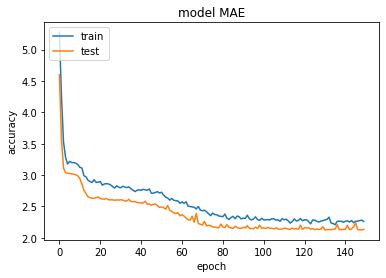

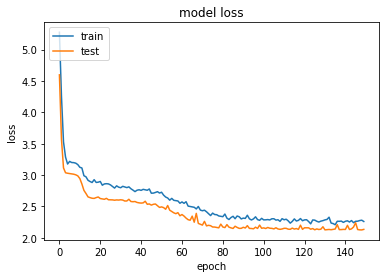

In [123]:
# list all data in history
print(build.history.keys())
# summarize history for accuracy
plt.plot(build.history['mae'])
plt.plot(build.history['val_mae'])
plt.title('model MAE')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(build.history['loss'])
plt.plot(build.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save("model.h5")
print("Saved model to disk")